# Presentation of the Tool

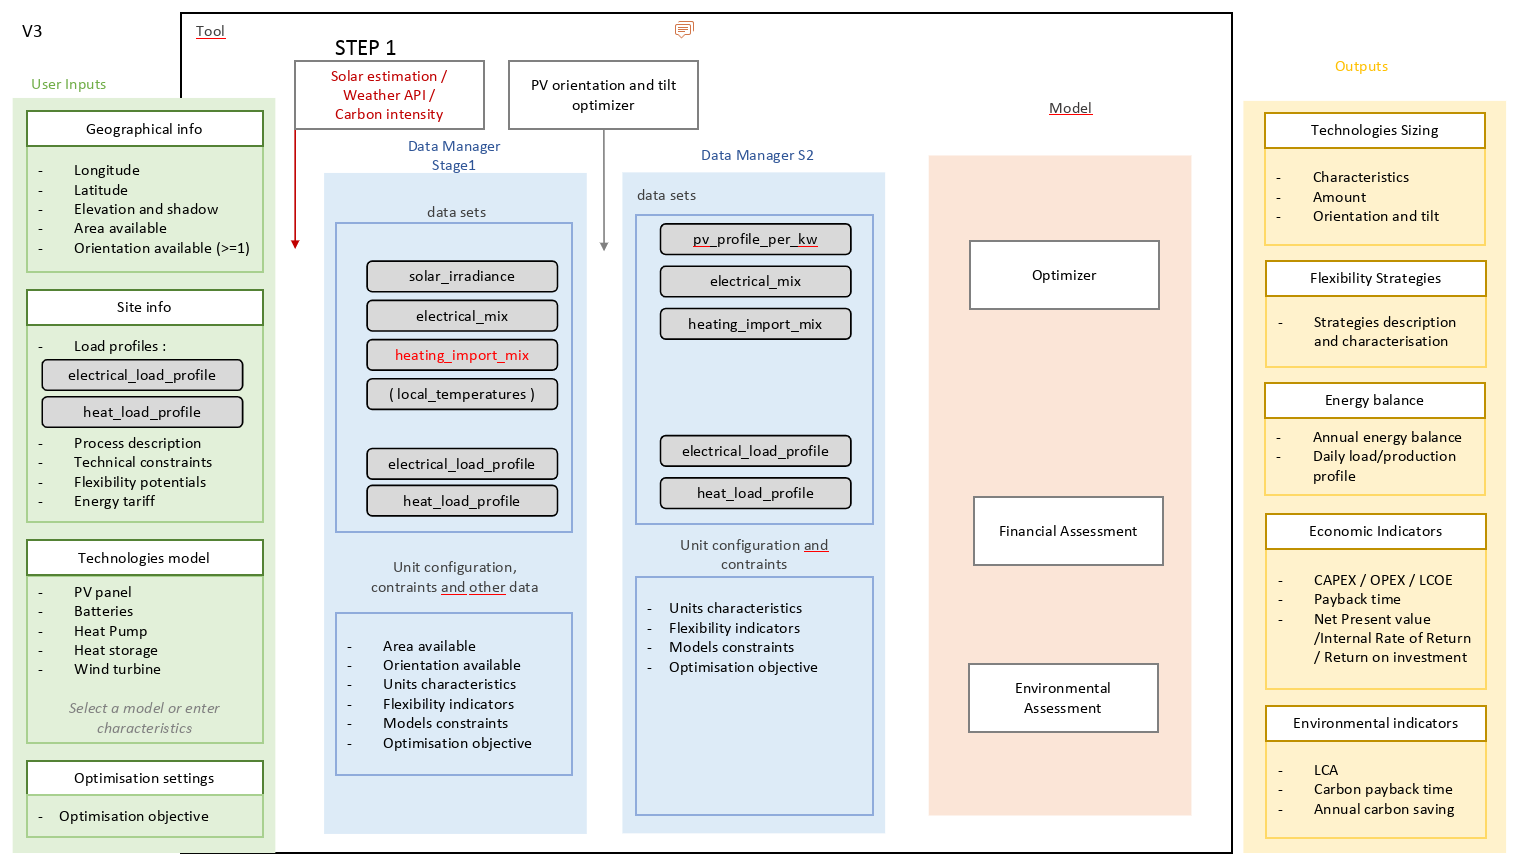

# Definition of Site Parameters

## About European Spallation Source
The European Spallation Source (ESS) is a European Research Infrastructure Consortium (ERIC), a multi-disciplinary research facility based on the world’s most powerful neutron source. Thier global vision is to build and operate the world’s most powerful accelerator-based neutron source, enabling scientific breakthroughs in research related to 
 * materials
 * energy
 * health 
 * environment
 Additionally, the research carried out at the ESS is envisonded to address some of the most important societal challenges of our time.

### ESS Logo
<img src="https://ess.eu/themes/custom/ess/logo.svg" alt="ESS logo" width="300">

### ESS Location
The European Spallation Source is under construction on the outskirts of Lund, a city in southern Sweden.
The geographic paramters of the site are listed below:

* Longitude: 13.248
* Latitude: 55.734
* Altitude: 76


<img src="https://ess.eu/sites/default/files/styles/article_image/public/images/media/2024-03/DJI_0269.jpg?itok=ZSlvwWan" alt="ESS Ariel View" width="800">


# Specifics of the site and the installation

![image.png](Figures/Lund_PV.JPG)

* The image above was sourced from [here](https://profilesolar.com/locations/Sweden/Lund/)
* a tilt angle of 46° is recommended 
* and azimuth of 180° (south)

In [ ]:
import subprocess
import sys
from pkg_resources import get_distribution, DistributionNotFound, VersionConflict, Requirement

def install_requirements(file="requirements.txt"):
    try:
        with open(file) as f:
            packages = [
                line.strip() for line in f 
                if line.strip() and not line.startswith("#") and not line.lower().startswith("python")
            ]
        for pkg in packages:
            try:
                # Check if package satisfies requirement
                get_distribution(pkg)
                print(f"Package OK: {pkg}")
            except (DistributionNotFound, VersionConflict):
                print(f"Installing or upgrading package: {pkg}")
                subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", pkg])
    except FileNotFoundError:
        print(f"{file} not found.")

install_requirements()


In [ ]:
import pvlib
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain

import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

from pvlib.pvsystem import PVSystem
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

import plotly.express as px

import requests


import pydeck as pdk
from IPython.display import display

from shapely.geometry import Polygon, box
import math
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import os

In [ ]:
##########SITE PARAMETERS############
name = "Lund"
altitude = 76 # in meters
longitude = 13.248
latitude = 55.734
tz='Europe/Paris'
building_height = 9
available_surface = 70000  # value in m²
altitude += building_height
##########PV INSTALLATION PARAMETERS############

surface_tilt = 41
surface_azimuth = 180 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = pvlib.albedo.SURFACE_ALBEDOS["concrete"]

In [ ]:
# Create a pvlib location object
location = Location(name = name , latitude=latitude, longitude=longitude, altitude=altitude, tz=tz,)
location

## Add the modules
in the next cell , the PV module and Inverter module are selected as :

* Inverter : [SMA_America__SB10000TL_US__240V_](https://www.solaris-shop.com/sma-sunny-boy-sb10000tl-us-12-10kw-string-inverter/?srsltid=AfmBOooQM-9rbcLe9KFdQQxR1_xMD6_1ds2GNlUjxUX9YP4dD2ZhfGSh)
* PV Module: [Jinko_Solar_Co___Ltd_JKM410M_72HL](https://www.solarelectricsupply.com/jinko-eagle-g2-jkm410m-72hl-v-410w-perc-solar-panel?srsltid=AfmBOoq6GapbtrAL_kjIl9OYEN_FFcP1gbMhmMbW8sL93WkZqHQq3yzn)

**Note that these modules are not the latest and might be outdated, however the resulting production curves are still relevant**

In [ ]:
############ PV MODULE ############

pv_modules = pvlib.pvsystem.retrieve_sam('CECMod')
cec_module = pv_modules["Jinko_Solar_Co___Ltd_JKM410M_72HL"]
panel_area = cec_module.A_c

############ INVERTER ############
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
cec_inverter = cec_inverters['SMA_America__SC_2750_EV_US__600V_']

############ SYSTEM DIMENSIONING ############
mod_per_string = round(cec_inverter.Vdcmax/cec_module.V_oc_ref, 0) -1
total_panels = round(cec_inverter.Pdco/cec_module.PTC, 0)
strings = total_panels/mod_per_string



total_surface_per_inv = total_panels * panel_area
no_inverters = int(available_surface / total_surface_per_inv)


print(f"\nTotal number of PV modules : {total_panels}")
print(f"\nTotal Number of PV panels per string : {mod_per_string}")
print(f"\nTotal number of strings : {strings} ")
print (f"\nInput Power (DC) STC per inverter: {round((total_panels *cec_module.STC)/1000,2) }kW")
print (f"\nInput Power (DC) PTC per inverter: {round((total_panels *cec_module.PTC)/1000, 2 )}kW")
print (f"\nTotal number of invertes: {no_inverters}")


In [ ]:
new_building = {
    'coordinates': [
        [
            (13.244860, 55.733250),
            (13.244772, 55.733388),
            (13.245062, 55.733447),
            (13.244930, 55.733605),
            (13.245349, 55.733732),
            (13.245453, 55.733643),
            (13.245418, 55.733852),
            (13.245945, 55.734014),
            (13.246129, 55.733825),
            (13.245748, 55.733692),
            (13.245830, 55.733620),
            (13.245941, 55.733712),
            (13.246181, 55.733523),
            (13.245822, 55.733367),
            (13.245741, 55.733420),
            (13.245598, 55.733355),
            (13.245591, 55.733373),
            (13.245651, 55.733316),
            (13.245329, 55.733186),
            (13.245184, 55.733293),
            (13.244860, 55.733250)
        ]
    ],
    'elevation': 3,
    'name': 'Manual Building'
}

### 3D Representation of the Site 

In [ ]:
def add_panels(building,panels = [],
               panel_w_m=1.6,
               panel_h_m=1.0,
               spacing_m=0.2,
               panel_thickness_m=0.05,
               offset_above_roof_m=0.05):
    """
    Given a single building dict, return a flat list of panel feature dicts clipped to the roof.
    Each panel dict has keys: "coordinates" (list of rings), "elevation", "name".
    """
    

    # Basic validation
    if not building or 'coordinates' not in building or not building['coordinates']:
        return panels

    # Use roof polygon (pydeck uses (lon, lat) ordering)
    roof_coords = building['coordinates'][0]
    roof_poly = Polygon(roof_coords)
    if not roof_poly.is_valid:
        roof_poly = roof_poly.buffer(0)
        if not roof_poly.is_valid:
            return panels

    # conversion meters -> degrees at building latitude (approx)
    centroid_lat = roof_poly.centroid.y
    meters_per_deg_lat = 111320.0
    meters_per_deg_lon = 111320.0 * math.cos(math.radians(centroid_lat))
    if meters_per_deg_lon <= 0:
        meters_per_deg_lon = 1e-6

    panel_w_deg = panel_w_m / meters_per_deg_lon
    panel_h_deg = panel_h_m / meters_per_deg_lat
    spacing_deg_x = spacing_m / meters_per_deg_lon
    spacing_deg_y = spacing_m / meters_per_deg_lat

    # Shrink roof slightly so edge-touching panels aren't rejected by strict within()
    shrink_eps = min(panel_w_deg, panel_h_deg) * 0.05
    roof_poly_shrunk = roof_poly.buffer(-shrink_eps)
    if roof_poly_shrunk.is_empty:
        roof_poly_shrunk = roof_poly

    min_lon, min_lat, max_lon, max_lat = roof_poly_shrunk.bounds

    # Generate grid candidates in lon/lat degrees
    candidates = []
    lon = min_lon
    eps = 1e-12
    while lon + panel_w_deg <= max_lon + eps:
        lat = min_lat
        while lat + panel_h_deg <= max_lat + eps:
            rect = box(lon, lat, lon + panel_w_deg, lat + panel_h_deg)
            candidates.append(rect)
            lat += panel_h_deg + spacing_deg_y
        lon += panel_w_deg + spacing_deg_x

    # Keep only panels fully inside the shrunk roof polygon
    for rect in candidates:
        if rect.within(roof_poly_shrunk):
            coords = list(rect.exterior.coords)
            panels.append({
                "coordinates": [coords],
                "elevation": building['elevation'] + panel_thickness_m + offset_above_roof_m,
                "name": f"{building.get('name','building')}_panel"
            })

    # Fallback: try scaled-down panels if none fit
    if len(panels) == 0:
        for factor in (0.75, 0.5, 0.33, 0.25):
            pw = panel_w_deg * factor
            ph = panel_h_deg * factor
            sx = spacing_deg_x * factor
            sy = spacing_deg_y * factor
            candidates = []
            lon = min_lon
            while lon + pw <= max_lon + eps:
                lat = min_lat
                while lat + ph <= max_lat + eps:
                    rect = box(lon, lat, lon + pw, lat + ph)
                    candidates.append(rect)
                    lat += ph + sy
                lon += pw + sx
            for rect in candidates:
                if rect.within(roof_poly_shrunk):
                    coords = list(rect.exterior.coords)
                    panels.append({
                        "coordinates": [coords],
                        "elevation": building['elevation'] + panel_thickness_m + offset_above_roof_m,
                        "name": f"{building.get('name','building')}_panel"
                    })
            if panels:
                break

    return panels

In [ ]:
radius = 500  # meters
zoom = 15

mapbox_api_key  = 'pk.eyJ1IjoibmFuYWtheWpyIiwiYSI6ImNsd292bDZiNDE1NDgyaXJ6bzVnMmtndGwifQ.j9iruyIiAk4CBpVOaKsMJw'

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[out:json][timeout:800];
(
  way["building"](around:{radius},{latitude},{longitude});
  relation["building"](around:{radius},{latitude},{longitude});
);
(._;>;);
out body;
"""

resp = requests.get(overpass_url, params={'data': overpass_query})
resp.raise_for_status()
data = resp.json()

# Build node lookup (all nodes)
node_dict = {
    el['id']: (el['lat'], el['lon'])
    for el in data['elements'] if el['type'] == 'node'
}



# Extract buildings (polygons) same as before, only for those ways for which all nodes are resolved
buildings = []
for el in data['elements']:
    if el['type'] == 'way' and 'tags' in el and 'building' in el['tags']:
        nodes = el.get('nodes', [])
        coords = []
        all_present = True
        for nid in nodes:
            if nid in node_dict:
                lat, lon = node_dict[nid]
                coords.append((lon, lat))
            else:
                all_present = False
                break
        if not all_present:
            continue
        if len(coords) > 2:
            # close polygon
            if coords[0] != coords[-1]:
                coords.append(coords[0])
            levels = int(el['tags'].get('building:levels', '1'))
            elevation = levels * 3
            buildings.append({
                'coordinates': [coords],
                'elevation': elevation,
                'name': el['tags'].get('name', 'N/A')
            })

# Define Pydeck layers
buildings.append(new_building)
i = 1
panels = []
solar_roof= ["Manual Building"]
for building in buildings:
    if "N/A" in building["name"]:
        building["name"]= f"Building_{i}"
    if building["name"] in solar_roof:
        panels = add_panels(building=building, panels=panels)

    i +=1

    
building_layer = pdk.Layer(
    "PolygonLayer",
    buildings,
    get_polygon="coordinates",
    extruded=True,
    get_elevation="elevation",
    get_fill_color=[200, 160, 200, 180],
    stroked=True,
    get_line_color=[80, 80, 80],
    pickable=True
)
solar_layer = pdk.Layer(
        "PolygonLayer",
        panels,
        get_polygon="coordinates",
        extruded=True,
        get_elevation="elevation",
        get_fill_color=[30, 90, 160, 220],
        stroked=True,
        get_line_color=[10, 10, 10],
        pickable=True
    )


view_state = pdk.ViewState(
    latitude=latitude,
    longitude=longitude,
    zoom=zoom,
    pitch=45,
    bearing=0
)

deck = pdk.Deck(
    layers=[building_layer, solar_layer],
    initial_view_state=view_state,
    map_provider = "mapbox",
    map_style='mapbox://styles/mapbox/streets-v12',
    api_keys={'mapbox': mapbox_api_key},
    height=600
)

deck.show()

## Request for Weather Data

The weather data is sourced from [open-meteo](https://open-meteo.com/)

The following paramters are extracted:

* Relative humidity [%]
* Pressure [hpa]
* Cloud cover [%]
* Wind direction [°]
* Ambient Temperature [°C]
* Wind speed [m/s]
* GHI [W/m²]
* DNI [W/m²]
* DHI [W/m²]
* Direct radiation [W/m²]
* Rain [mm]
* Snowfall [cm]


In [ ]:


# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": latitude,
	"longitude": longitude,
	"start_date": "2005-01-01",
	"end_date": "2024-12-31",
    "wind_speed_unit": "ms",
    "timezone": "Europe/Stockholm",
	"hourly": ["temperature_2m", "relative_humidity_2m", "rain", "snowfall", "surface_pressure", "cloud_cover", "wind_speed_10m", "wind_direction_10m", "shortwave_radiation", "direct_radiation", "diffuse_radiation", "direct_normal_irradiance"],
	}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(4).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(6).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(7).ValuesAsNumpy()
hourly_shortwave_radiation = hourly.Variables(8).ValuesAsNumpy()
hourly_direct_radiation = hourly.Variables(9).ValuesAsNumpy()
hourly_diffuse_radiation = hourly.Variables(10).ValuesAsNumpy()
hourly_direct_normal_irradiance = hourly.Variables(11).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["relative_humidity"] = hourly_relative_humidity_2m
hourly_data["pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_direction"] = hourly_wind_direction_10m
hourly_data["temp_air"] = hourly_temperature_2m
hourly_data["wind_speed"] = hourly_wind_speed_10m
hourly_data["ghi"] = hourly_shortwave_radiation
hourly_data["direct_radiation"] = hourly_direct_radiation
hourly_data["dhi"] = hourly_diffuse_radiation
hourly_data["dni"] = hourly_direct_normal_irradiance
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall

weather = pd.DataFrame(data = hourly_data)
weather.set_index('date', inplace = True)
weather = weather.tz_convert ('Europe/Stockholm')
fig = px.line(weather.loc[weather.index >= "2024"], template="plotly_white", title = "Plot of extracted weather data for 2024")
fig.show(renderer = "notebook")
# fig.show(renderer = "png")

## Fetch data from PVGIS

In [ ]:
# ONLY USE ONE SOURCE, DO NOT TRY TO USE PVGIS AND OPEN METEO AT THE SAME TIME

# poa_data_2023, meta, inputs = pvlib.iotools.get_pvgis_hourly(latitude=55.734170, longitude=13.247884,
#                                           start=2023, end=2023,
#                                           raddatabase="PVGIS-SARAH3", components=True,
#                                           surface_tilt=45, surface_azimuth=0,
#                                           outputformat='json', usehorizon=True,
#                                           userhorizon=None, pvcalculation=False,
#                                           peakpower=None, pvtechchoice='crystSi',
#                                           mountingplace='free', loss=0, trackingtype=0,
#                                           optimal_surface_tilt=False, optimalangles=False,
#                                           url='https://re.jrc.ec.europa.eu/api/',
#                                           map_variables=True, timeout=30)

# poa_data_2023['poa_diffuse'] = poa_data_2023['poa_sky_diffuse']+poa_data_2023['poa_ground_diffuse']
# poa_data_2023['poa_global'] = poa_data_2023['poa_diffuse'] + poa_data_2023['poa_direct']
# #poa_data_2023['poa_air'] =
# #poa_data_2023['poa_speed'] =

# print(poa_data_2023)

# poa_data_2023.to_csv("pvgis_tmy_ESS_2005_2023_io.csv")

# #              READ DATA WE JUST FETCHED FROM PVGIS
# tmy = pd.read_csv("pvgis_tmy_ESS_2005_2023.csv", skiprows=17, nrows=8760, sep=";", 
#                   usecols=["time(UTC)", "G(h)", "Gb(n)", "Gd(h)"], 
#                   index_col=0)  # Here I can add any of the other available parameters provided PVGIS: "T2m" "RH" "Bb(n)" "Bd(h)" "IR(h)"


# tmy.index= pd.date_range(start="2023-01-01 00:00", end="2023-12-31 23:00", freq="h")
# tmy.columns = ["Ghi", "Dni", "Dhi"] # Here I rename the colums I read

# print(tmy)

# tmy.plot(figsize=(16,9))
# plt.ylabel('Irradiance (W/m2)')
# plt.show()

### Create a Temperature model for the PV Modules 

In [ ]:

temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']

temperature_model_parameters

In [ ]:
system = PVSystem(
                 surface_tilt=surface_tilt, 
                 surface_azimuth=surface_azimuth,
                 module_parameters=cec_module,
                 inverter_parameters=cec_inverter,
                 temperature_model_parameters=temperature_model_parameters,
                 albedo=albedo, 
                 surface_type=None, 
                 module=None, 
                 module_type='glass_polymer',
                 modules_per_string=mod_per_string, 
                 strings_per_inverter=strings, 
                 inverter=None, 
                 racking_model='open_rack', 
                 losses_parameters=None, 
                 name='ESS_Lund'
                 )

In [ ]:
mc = ModelChain(
                system, location, name=name, 
                clearsky_model='ineichen',
                transposition_model='haydavies',
                solar_position_method='nrel_numpy', 
                airmass_model='kastenyoung1989',
                dc_model="cec", #from module specifications
                ac_model='sandia', #from inverter specifications
                aoi_model='physical', 
                spectral_model='no_loss', #spectral model 'no loss' otherwise error
                temperature_model='sapm',
                 losses_model='pvwatts'
                 )

## Run the Model with clear sky irradiation data
Here, the model does not consider cloud cover and assumes maximum irradiation all the time

In [ ]:
mc.run_model(weather)

In [ ]:
dc = mc.results.dc.p_mp.tolist()
ac = mc.results.ac.tolist()
c_t = mc.results.cell_temperature.tolist()


# ind = 
df = pd.DataFrame({"Power_dc" : dc , "Power_ac" : ac , "cell_temp" : c_t}, index= mc.results.times)
df.loc[:, ["Power_dc", "Power_ac"]] *= no_inverters

df_plot = df.loc[df.index>="2024"]


fig = px.line(df_plot[["Power_dc", "Power_ac" ]]/1000, template = "plotly_white", title = "Hourly PV Production [W]")
fig.update_yaxes(title_text="Power [kW]")
fig.show(renderer = "notebook")
# fig.show(renderer = "png")

fig_1 = px.line(df_plot[["cell_temp" ]], template = "plotly_white", title = "Hourly PV Cell Temperature [°C]")
fig_1.update_yaxes(title_text="Temperature [°C]")
fig_1.show(renderer = "notebook")
# fig_1.show(renderer = "png")

fig_2 = px.bar(df[["Power_dc", "Power_ac" ]].resample("1Y").sum()/1e6,barmode ="group", template = "plotly_white", title = "Estimated Annual Energy production - Clear Sky [GWh]" )
fig_2.update_yaxes(title_text="Energy [MWh]")
fig_2.show(renderer = "notebook")
# fig_2.show(renderer = "png")

# Accounting for cloud cover
code below replicates the forecast method for GHI as depicted in [readthedocs](https://pvlib-python.readthedocs.io/en/v0.5.2/_modules/pvlib/forecast.html#ForecastModel.cloud_cover_to_ghi_linear) for the ```cloud_cover_to_ghi_linear``` method. Subsequently the DNI and DHI are recalculated using a the ```erbs``` function from pvlib

In [ ]:
weather_1 = weather.copy()
offset = 0.35 

solar_position = location.get_solarposition(weather_1.index)
zenith = solar_position["apparent_zenith"]



weather_1["ghi"] *=  (offset + (1 - offset) * (1 - weather_1["cloud_cover"] / 100))


# weather_1["ghi"] *=  (1 - weather_1["cloud_cover"] / 100)
data = pvlib.irradiance.erbs(
        ghi=weather_1["ghi"],
        datetime_or_doy = weather_1.index,
        zenith=zenith,
    )

weather_1["dni"] = data.dni
weather_1["dhi"] = data.dhi

In [ ]:
mc.run_model(weather_1)

In [ ]:
dc = mc.results.dc.p_mp.tolist()
ac = mc.results.ac.tolist()
c_t = mc.results.cell_temperature.tolist()
# ind = 
df_1 = pd.DataFrame({"Power_dc" : dc , "Power_ac" : ac , "cell_temp" : c_t}, index= mc.results.times)
df_1.loc[:, ["Power_dc", "Power_ac"]] *= no_inverters

df_plot = df_1.loc[df.index>="2024"]
fig = px.line(df_plot[["Power_dc", "Power_ac" ]]/1000, template = "plotly_white", title = "Hourly PV Production [KW]")
fig.update_yaxes(title_text="Power [kW]")
# fig.show(renderer = "notebook")
# fig.show(renderer = "png")


fig_1 = px.line(df_plot[["cell_temp" ]], template = "plotly_white", title = "Hourly PV Cell Temperature [°C]")
fig_1.update_yaxes(title_text="Temperature [°C]")
# fig_1.show(renderer = "notebook")
# fig_1.show(renderer = "png")

fig_2 = px.bar(df_1[["Power_dc", "Power_ac" ]].resample("1YE",label="left").sum()/1e9,barmode ="group", template = "plotly_white", title = "Estimated Annual Energy production - Cloudy Sky[GWh]" )
fig_2.update_yaxes(title_text="Energy [GWh]")
# fig_2.show(renderer = "png")
# fig_2.show(renderer = "notebook")

In [ ]:
temp =pd.DataFrame(index=df.index)

temp ["Power_dc[clear_sky]"] = df.Power_dc
temp ["Power_dc[cloudy_sky]"] = df_1.Power_dc

fig_1 = px.bar(temp.resample("1ME",label="left").sum()/1e6, template="plotly_white", title = "Comparison of clear sky and cloudy sky results [MWh]", barmode = "group" )
fig_1.update_yaxes(title_text="Energy [MWh]")
fig_1.show(renderer = "notebook")

In [ ]:
# temp_ = weather["cloud_cover"].groupby(weather["cloud_cover"].index.year).apply(lambda x: x.values).apply(pd.Series)

# px.line (temp_.T)

In [ ]:

gen = temp.resample("1h").mean().resample("1YE" , label = "left").sum()/1e9
gen = gen.iloc[1:]

fig = go.Figure()
gen

fig.add_trace(go.Scatter(
    x=gen.index,
    y=gen['Power_dc[clear_sky]'],
    mode='lines',
    name='Clear_sky',
    line=dict(color='orange')
))

# Lower line (cloudy)
fig.add_trace(go.Scatter(
    y=gen['Power_dc[cloudy_sky]'],
    x=gen.index,
    mode='lines',
    name='Cloudy_sky',
    line=dict(color='blue'),
    fill='tonexty',        # fill area between this trace and the previous one
    fillcolor='rgba(0,0,255,0.2)'  # semi-transparent blue
))

fig.update_layout(
    title="Clear Sky vs Cloudy Sky",
    xaxis_title="Time",
    yaxis_title="Value",
    template = "plotly_white",
    yaxis = {"title_text" : "Energy [GWh]"}
)

fig.update_yaxes()
fig.show()


# Levelized Cost of Energy (LCOE)

## What is LCOE?

LCOE is the constant price per unit of electricity (usually €/MWh or ¢/kWh) that makes the present value of a generator’s costs equal to the present value of the electricity it produces over its lifetime. It is commonly used to compare the average cost of electricity from different technologies.

### Formulation

**Discounted form:**

```math
LCOE = \frac{\sum_{t=0}^{N} \frac{I_t + O_t + F_t}{(1+r)^t}}{\sum_{t=0}^{N} \frac{E_t}{(1+r)^t}}
```

Where:

* $`I_t`$ = investment (capital) expenditures in year t
* $`O_t`$ = operations & maintenance costs in year t
* $`F_t`$ = fuel costs in year t (0 for wind/solar)
* $`E_t`$ = electricity produced in year t (MWh or kWh)
* $`r`$ = discount rate (often WACC)
* $`N`$ = project lifetime (years)

### Key Drivers

* Capital cost (CAPEX) and financing (discount rate)
* Capacity factor (higher CF → lower LCOE for same CAPEX)
* Fuel costs (important for fossil fuels)
* O\&M costs and major replacements
* Lifetime and degradation
* Subsidies, tax credits, carbon pricing

### Uses

* Comparing technology costs (wind vs solar vs gas)
* Policy evaluation (impact of subsidies, carbon pricing)
* Project finance / tariff setting / auctions

### Limitations

* Ignores **time-value of energy** (when electricity is produced)
* Does not include **system integration costs** (grid reinforcement, storage)
* Omits **risk & flexibility contributions**
* Highly sensitive to assumptions (discount rate, capacity factor, lifetime)


In [ ]:
# power values in W and need to be converted to kW
gen = temp.resample("1h").mean().resample("1YE" , label = "right").sum()/1e3

# Example variables
project_lifetime = 20       # years
discount_rate = 0.07        # 7% discount rate
degradation_rate = 0.005    # 0.5%/year
capex = 6000000           # initial investment ($)
om = 0.03 * capex                 # annual O&M ($)
periodic_cost = 0.1*capex
periodic_cost_freq = 5
# Initialize LCOE DataFrame
lcoe_df = pd.DataFrame({
    "capex": [0]* (project_lifetime + 1),
    "Operations_Cost": [om] * (project_lifetime + 1),
    "Periodic_Costs": [periodic_cost if year%periodic_cost_freq == 0 and year > 0 else 0 for year in range(project_lifetime + 1)],
    "Fuel": [0] * (project_lifetime + 1),
    "Annual_Cost": [0] * (project_lifetime + 1),
    "Annual_Generation_Clear": gen["Power_dc[clear_sky]"].tolist(),
    "Annual_Generation_Cloudy": gen["Power_dc[cloudy_sky]"].tolist(),
    "Annual_Degradation": [(1 - degradation_rate)**(year-1) for year in range (project_lifetime+1)],
    "Discounted_Annual_Costs": [0.0] * (project_lifetime + 1),
    "Discounted_Annual_Energy": [0.0] * (project_lifetime + 1),
})

# Add CAPEX in year 0
lcoe_df.loc[0, "capex"] = capex

# Compute annual generation with degradation
lcoe_df["Annual_Generation_Clear"] = lcoe_df["Annual_Generation_Clear"] * lcoe_df["Annual_Degradation"]
lcoe_df["Annual_Generation_Cloudy"] = lcoe_df["Annual_Generation_Cloudy"] * lcoe_df["Annual_Degradation"]
lcoe_df["Annual_Cost"] = lcoe_df[["capex", "Operations_Cost", "Periodic_Costs", "Fuel"]].sum(axis = 1)
# Apply discounting
for year in range(project_lifetime + 1):
    discount_factor = (1 + discount_rate)**year
    
   
    lcoe_df.loc[year, "Discounted_Annual_Costs"] = lcoe_df.loc[year , "Annual_Cost"] / discount_factor
    lcoe_df.loc[year, "Discounted_Annual_Energy_clear"] = lcoe_df.loc[year, "Annual_Generation_Clear"] / discount_factor
    lcoe_df.loc[year, "Discounted_Annual_Energy_cloudy"] = lcoe_df.loc[year, "Annual_Generation_Cloudy"] / discount_factor

# Compute LCOE
NPV_costs = lcoe_df["Discounted_Annual_Costs"].sum()
NPV_energy_clear = lcoe_df["Discounted_Annual_Energy_clear"].sum()
NPV_energy_cloudy = lcoe_df["Discounted_Annual_Energy_cloudy"].sum()



print(f"\n Best Case (Clear sky) Levelized Cost of Energy (LCOE): {round(NPV_costs / NPV_energy_clear, 3)} $/kWh")
print(f"\n Worst Case (Cloudy sky) Levelized Cost of Energy (LCOE): {round(NPV_costs / NPV_energy_cloudy,3)} $/kWh")

# Discounted Payback Period (DPP)

## What is Discounted Payback Period?

The **Discounted Payback Period (DPP)** is the time it takes for the cumulative present value of cash inflows from a project to equal the initial investment, taking into account the **time value of money**. Unlike the regular payback period, DPP considers discounting of future cash flows.

## Formula

```math
DPP = \text{Time when cumulative discounted inflows} = \text{Initial Investment}
```

Step-by-step:

1. Determine the discount rate (r), usually WACC or required rate of return.
2. Calculate the **discounted cash inflow** for each period:

```math
DCF_t = \frac{CF_t}{(1+r)^t}
```

Where:

* $`CF_t`$ = cash inflow at year t
* $`r`$ = discount rate
* $`t`$ = year

3. Sum discounted cash inflows cumulatively until the total equals or exceeds the initial investment.

## Key Points

* Accounts for the **time value of money**, unlike regular payback period.
* Provides a measure of how quickly a project recovers its investment **in present-value terms**.
* Shorter DPP indicates faster recovery and lower risk.

## Limitations

* Does not consider cash flows after the payback period.
* Sensitive to discount rate selection.
* Provides no direct measure of overall profitability (use NPV or IRR for that).



In [ ]:
electricity_price = 0.2

price_escalation = 0.05

# Annual electricity price escalation rate
escalation_rate = 0.02  # 2%/year

# Compute annual electricity price with escalation
electricity_prices = electricity_price * ((1 + escalation_rate) ** lcoe_df.index)

# Update revenue
lcoe_df['Annual_Revenue'] = lcoe_df['Annual_Generation_Clear'] * electricity_prices

# Recalculate cumulative net cashflow (simple)
lcoe_df['Cumulative_Net_CashFlow_Simple'] = (lcoe_df['Annual_Revenue'] - lcoe_df['Annual_Cost']).cumsum()
simple_payback_year = lcoe_df[lcoe_df['Cumulative_Net_CashFlow_Simple'] >= 0].index.min()
print(f"Simple payback year with escalation: {simple_payback_year}")

# Recalculate discounted net cashflow
lcoe_df['Discounted_Annual_Revenue'] = lcoe_df['Annual_Revenue'] / ((1 + discount_rate) ** lcoe_df.index)
lcoe_df['Discounted_Cumulative_Net_CashFlow'] = (lcoe_df['Discounted_Annual_Revenue'] - lcoe_df['Discounted_Annual_Costs']).cumsum()
discounted_payback_year = lcoe_df[lcoe_df['Discounted_Cumulative_Net_CashFlow'] >= 0].index.min()
print(f"Discounted payback year with escalation: {discounted_payback_year}")

fig = px.line(lcoe_df, x=lcoe_df.index, y='Discounted_Cumulative_Net_CashFlow', template="plotly_white",
                labels={'x':'Year','Discounted_Cumulative_Net_CashFlow':'Discounted Cumulative Net Cash Flow (€)'},
                title='Discounted Cumulative Net Cash Flow')


# Add zero line
fig.add_hline(y=0, line_dash='dash', line_color='black')

fig.update_layout(xaxis = {"title_text" : "YEAR"})

# Fill area under the curve
fig.update_traces(fill='tozeroy')


fig.show()

# Environmental Indicators

In [ ]:


dirs = ["data" ]
df_co = pd.DataFrame()

countries = {"FR": "France",
             "NL": "Netherlands",
             "SE": "Sweden",
             "HU": "Hungary",
             "CZ": "Czech Republic"}
for dir in dirs:
    for file in os.listdir(dir):
        
        if "CZ" in file or "SE" in file and file.endswith(".csv") :
            print (f"Treating {file} in {dir} \n")
            file_name = f"{dir}/{file}"
            
            mag = file.split("_")[0]
            

            temp = pd.read_csv(file_name,  header=0,sep = ",", decimal = "." , usecols= ['Carbon Intensity gCO₂eq/kWh (LCA)', "Datetime (UTC)"], index_col="Datetime (UTC)", parse_dates=True)            
            

            temp.columns = [mag]

            
            df_co = pd.concat([df_co,temp.sort_index(ascending=True)], axis= 1)
            
# df.fillna(0, inplace = True)
df_co

df_co = df_co.resample("1h").mean()

years = 20
rate = 0.05
temp = df_co.copy()
for year in range (1,years,1):
    t = temp.copy()
    t.index = t.index + pd.DateOffset(years=year)
    t *= ((1 - rate) ** year)

    df_co = pd.concat([df_co, t])


df_co.index = pd.date_range(start="2004-12-31 23:00", periods = len(df_co), freq = "1h")

df_co = df_co.loc[df_co.index <"2024-12-31 23:00"]

In [ ]:
carbon_capex = 80000 * (total_panels * no_inverters * (cec_module.PTC/1000))

df_co["Clear_sky_AC"] = (df["Power_dc"]/1000).tolist()
df_co["Cloudy_sky_AC"] = (df_1["Power_dc"]/1000).tolist()

# Compute avoided CO2 for each hour under each scenario
# “SE” and “CZ” are assumed to be emission intensities (kg CO2 per unit power)
df_co["Avoided_Co2_SE_ClearSky"] = df_co["Clear_sky_AC"] * df_co["SE"]
df_co["Avoided_Co2_CZ_ClearSky"]   = df_co["Clear_sky_AC"] * df_co["CZ"]

df_co["Avoided_Co2_SE_CloudySky"] = df_co["Cloudy_sky_AC"] * df_co["SE"]
df_co["Avoided_Co2_CZ_CloudySky"] = df_co["Cloudy_sky_AC"] * df_co["CZ"]

# Initialize columns for cumulative avoided CO2 and payback detection
# df_co = df_co.copy()

scenarios = [
    ("SE_ClearSky", "Avoided_Co2_SE_ClearSky"),
    ("CZ_ClearSky", "Avoided_Co2_CZ_ClearSky"),
    ("SE_CloudySky", "Avoided_Co2_SE_CloudySky"),
    ("CZ_CloudySky", "Avoided_Co2_CZ_CloudySky")
]

for label, avoided_col in scenarios:
    cum_col = f"Cumulative_{label}"
    
    # 1. Compute the cumulative sum of the avoided CO2
    df_co[cum_col] = df_co[avoided_col].cumsum()
    
    # 2. Subtract the carbon capex so that at t=0, it's negative and we see how long until it crosses 0
    df_co[cum_col] = df_co[cum_col] - carbon_capex


In [ ]:
cols = [col for col in df_co.columns if "Cumu" in col]

fig = px.line(df_co[cols].resample("1ME").asfreq()/1000,  title = "Carbon Payback")
fig.update_traces(fill='tozeroy')
fig.add_hline(y=0, line_dash='dash', line_color='black')

fig.update_layout(template= 'plotly_white', xaxis = {"title_text" : "Date"}, yaxis = {"title_text" : "CO2 [kGCO2eqv]"})